# MARL EVAL Tools quickstart notebook
This notebook provides an easy introduction to the Eval repo by showing an example of how to use different plotting tools.


### 1. Installing packages
We start by installing the necessary packages

In [1]:
#@title Install required packages. (Run Cell)

#install requirement (this needs to have the pip install)
!pip install "git+https://github.com/instadeepai/marl-eval.git"

### 2. Import the necessary modules
We first import the necessary modules that will be used to processing MARL experiment data and showing the plots

In [2]:
#@title Import required packages. (Run Cell)

# In case marl_tools not detected
import sys
sys.path.insert(1, "../")


import json

from marl_eval.plotting_tools.plotting import (
    aggregate_scores,
    performance_profiles,
    plot_single_task,
    probability_of_improvement,
    sample_efficiency_curves,
)

from marl_eval.utils.data_processing_utils import (
    create_matrices_for_rliable,
    data_process_pipeline,
)

### 3. Data processing and preparation

Second, we import the json file, run the processing pipeline that will help to calculate the normalized values.

In case, you don't have data and you want to test the tools, you can run generate_dummy_smac_data to generate some data

In [3]:
# Import the data
with open("./example_results.json", "r") as data_file:
    raw_data = json.load(data_file)

# Choose the list of metrics to normalize
METRICS_TO_NORMALIZE = ["return"]

# Call data_process_pipeline to normalize the choosen metrics and to clean the data
processed_data = data_process_pipeline(
    raw_data=raw_data, metrics_to_normalize=METRICS_TO_NORMALIZE
)

# Save the processed data in different json file
with open("./processed_example.json", "w+") as f:
    json.dump(processed_data, f, indent=4)

We need two different matrices to be used to create the plots:
  
  **a)  metric_dictionary_return:**

  - The output will be a dictionary that have as keys the different metrics and as a value a full other dictionary that have the different algorithm with their related metric_matrix.

  - The metric_matrix of dimenetion (number of runs x number of tasks), include the normalised absolute results.

  **b)  final_metric_tensor_dictionary:**

  - The output format will be similar to the first one except the matrix that correspond to the algorithm.

  - The matrix of dimention (number of runs x number of tasks x number of logging steps), include the normalised metrics results.

create_matrices_for_rliable function have 3 args:

  - data_dictionary: Dictionary of processed data
  
  - environment_name: Name of environment for which arrays should be computed.

  - metrics_to_normalize: List of metric names of metrics that should be normalised.

In [4]:
environment_comparison_matrix, sample_effeciency_matrix = create_matrices_for_rliable(
    data_dictionary=processed_data,
    environment_name="env_1",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
)

### 4. Use MARL-Eval tools

**a) Performance_profiles**
   - It produces the Performance profile plots.
   
   - The function have 3 args:
      - Dictionary: Matrix
      
      - metric_name: Name of metric to produce plots for.
      - metrics_to_normalize: List of metrics that are normalised.

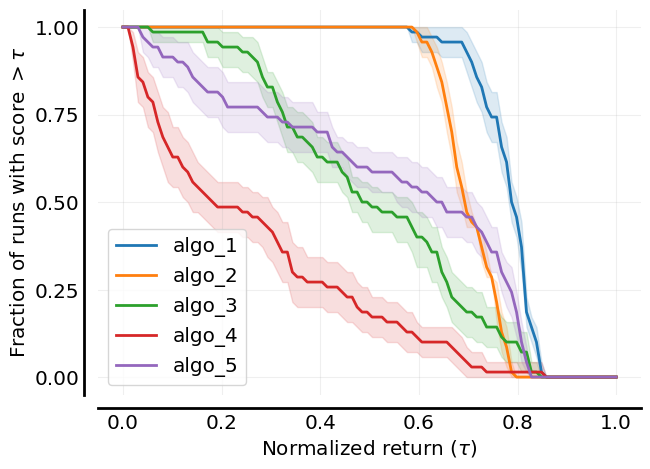

In [5]:
fig = performance_profiles(
    environment_comparison_matrix,
    metric_name="return",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
)


**b) Aggregate Score**
   - It produces the Aggregated Score plots and create a csv include the tabular results.
   
   - The function have 6 args:
      - Dictionary: Matrix
      
      - metric_name: Name of metric to produce plots for.
      - metrics_to_normalize: List of metrics that are normalised.
      - rounding_decimals:  number up to which the results values are rounded for the tabular results.
      - tabular_results_file_path: location to store the tabular results.
      - save_tabular_as_latex: get the tabular results as a latex table format.

The tabular results are stored in ./aggregated_score_return.csv and they are the following
                            algo_1             algo_2             algo_3  \
Median          0.78 [0.77, 0.79]  0.68 [0.67, 0.69]  0.53 [0.41, 0.62]   
IQM              0.79 [0.78, 0.8]    0.7 [0.7, 0.71]  0.51 [0.47, 0.54]   
Mean            0.78 [0.77, 0.79]    0.7 [0.7, 0.71]  0.51 [0.48, 0.53]   
Optimality Gap  0.22 [0.21, 0.23]    0.3 [0.29, 0.3]  0.49 [0.47, 0.52]   

                           algo_4             algo_5  
Median          0.27 [0.17, 0.35]  0.63 [0.55, 0.69]  
IQM             0.21 [0.17, 0.26]   0.6 [0.56, 0.64]  
Mean             0.26 [0.23, 0.3]  0.54 [0.51, 0.57]  
Optimality Gap   0.74 [0.7, 0.77]  0.46 [0.43, 0.49]  
The latex tabular results are stored in ./aggregated_score_return_latex.txt


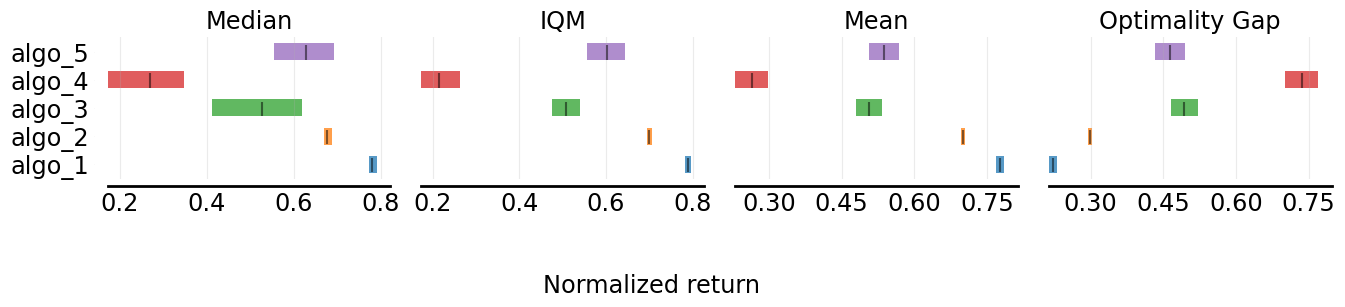

In [6]:
fig, _, _ = aggregate_scores(
    dictionary=environment_comparison_matrix,
    metric_name="return",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
    save_tabular_as_latex=True,
)

**C) Probability of Improvement**
   - It produces the probability of improvement plots.
   
   - The function have 4 args:
      - Dictionary: Matrix
      
      - metric_name: Name of metric to produce plots for.
      - metrics_to_normalize: List of metrics that are normalised.
      - algorithms_to_compare: 2D list containing pairs of algorithms to be compared (e.g. `[["QMIX", "VDN"], ["VDN", "MAPPO"], ["MADQN", "QMIX"]]`)

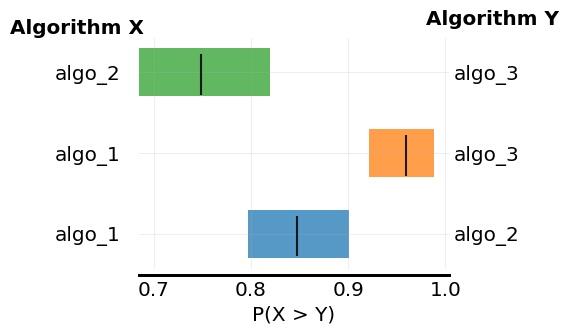

In [8]:
fig = probability_of_improvement(
    environment_comparison_matrix,
    metric_name="success_rate",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
    algorithms_to_compare=[["algo_1", "algo_2"], ["algo_1", "algo_3"], ["algo_2", "algo_3"]],
)

**d) Sample Efficiency Curves**
   - It produces the Sample Efficiency Curve plots.
   
   - The function have 3 args:
      - Dictionary: the sample_effeciency_matrix 
      
      - metric_name: Name of metric to produce plots for.
      - metrics_to_normalize: List of metrics that are normalised.

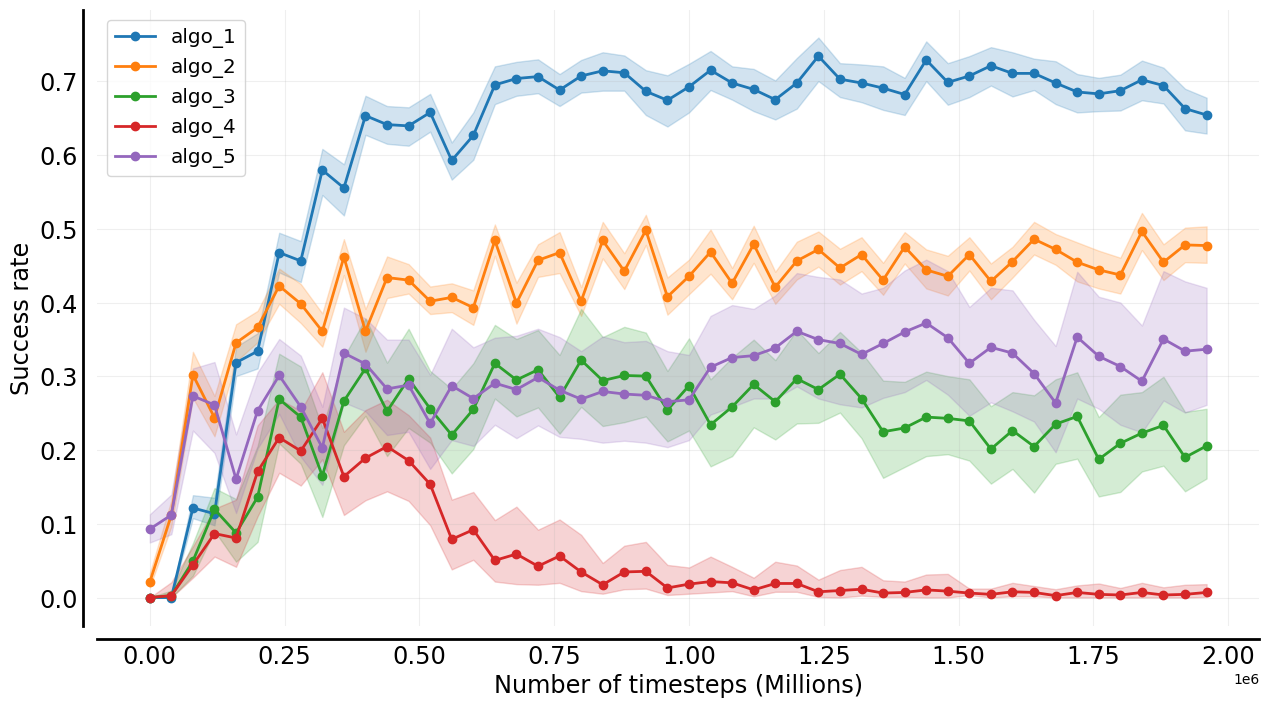

In [9]:
fig, _, _ = sample_efficiency_curves(
    dictionary=sample_effeciency_matrix,
    metric_name="success_rate",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
)

**e) Aggregate data over a single task**
   - Plots an aggregate metric with CIs as a function of environment frames.
   
   - The function have 3 args:
      - aggregated_data: Dictionary containing the mean and 95% CI at each
        evaluation step for all algorithms on a particular task.
        
      - algorithms: List of methods used for plotting. If None, defaults to all the
        keys in `point_estimates`.
      - colors: Dictionary that maps each algorithm to a color. If None, then this
        mapping is created based on `color_palette`.
      - color_palette: `seaborn.color_palette` object for mapping each method to a
        color.
      - figsize: Size of the figure passed to `matplotlib.subplots`. Only used when
        `ax` is None.
      - xlabel: Label for the x-axis.
      - ylabel: Label for the y-axis.
      - ax: `matplotlib.axes` object.
      - labelsize: Font size of the x-axis label.
      - ticklabelsize: Font size of the ticks.
      - **kwargs: Arbitrary keyword arguments.

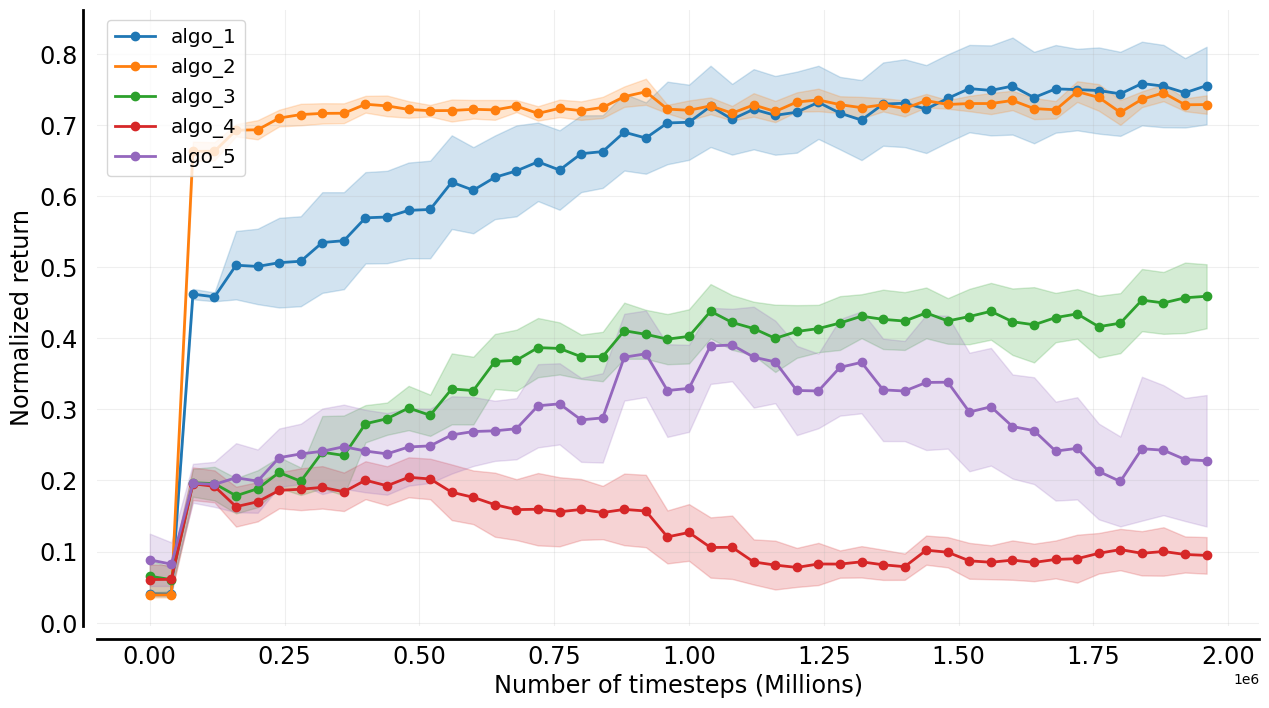

In [10]:
# Aggregate data over a single task
task = "task_1"
fig = plot_single_task(
    processed_data=processed_data,
    environment_name="env_1",
    task_name=task,
    metric_name="return",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
)